# Assingment 1 - Malaria Cell Image Classification
### Course: Convolutional Neural Networks with Applications in Medical Image Analysis

Office hours: Mondays 13.15--15.00 (Tommy), Tuesdays 13.15--16.00 (Minh), Thursdays 08.15--12.00 (Attila)

Welcome. The first assignment is based on classifying images of cells, whether they are parasitized or uninfected by malaria. Your input will be an image of a cell, and your output is a binary classifier. It is based on an open dataset, available from Lister Hill National Center for Biomedical Communications (NIH): https://lhncbc.nlm.nih.gov/publication/pub9932. You need to download the file ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip (as described in the assignment instructions). The data was preprocessed and organized for easier machine learning applications.

Your task is to look through the highly customizable code below, which contains all the main steps for high accuracy classification of these data, and improve upon the model. The most important issues with the current code are noted in the comments for easier comprehension. Your tasks, to include in the report, are:

- Reach an accuracy of at least 96~\% on the validation dataset.
- Plot the training/validating losses and accuracies. Describe when to stop training, and why that is a good choice.
- Describe the thought process behind building your model and choosing the model hyper-parameters.
- Describe what you think are the biggest issues with the current setup, and how to solve them.

In [0]:
# Import necessary packages for loading the dataset

import numpy as np  # Package for matrix operations, handling data
np.random.seed(2020)
import os
import cv2
import matplotlib.pyplot as plt  # Package for plotting
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical


import tensorflow as tf
from zipfile import ZipFile

# Path to dataset downloaded from the provided link
data_path = "cell_images"  # Path to dataset

In [0]:
# Download malaria-data

data_path = tf.keras.utils.get_file(
    fname="cell_images.zip", 
    origin="ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip", 
    extract=True,
)


zf = ZipFile(data_path, 'r')
zf.extractall('/root/.keras/datasets/cell_images')
zf.close()

data_path = '/root/.keras/datasets/cell_images'

In [24]:
# Download malaria-data

data_path = tf.keras.utils.get_file(
    fname="cell_images.zip", 
    origin="ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip", 
    extract=True,
)


print(data_path)

zf = ZipFile(data_path, 'r')
zf.extractall('/root/.keras/datasets/cell_images')
zf.close()

data_path = '/root/.keras/datasets/cell_images'

/root/.keras/datasets/cell_images.zip


In [25]:
# Check out dataset
parasitized_data = os.listdir(data_path + '/Parasitized/')
print(parasitized_data[:2])  # the output we get are the .png files
print("Number of parasitized images: " + str(len(parasitized_data)) + '\n')
uninfected_data = os.listdir(data_path + '/Uninfected/')
print(uninfected_data[:2])
print("Number of non-paratisized images: " + str(len(uninfected_data)))

# NOTE: The images are in .png format, they will have to be loaded individually and handled accordingly.

['C68P29N_ThinF_IMG_20150819_134830_cell_43.png', 'C180P141NThinF_IMG_20151201_170021_cell_11.png']
Number of parasitized images: 13780

['C164P125ThinF_IMG_20151116_120135_cell_129.png', 'C143P104ThinF_IMG_20151005_225454_cell_145.png']
Number of non-paratisized images: 13780


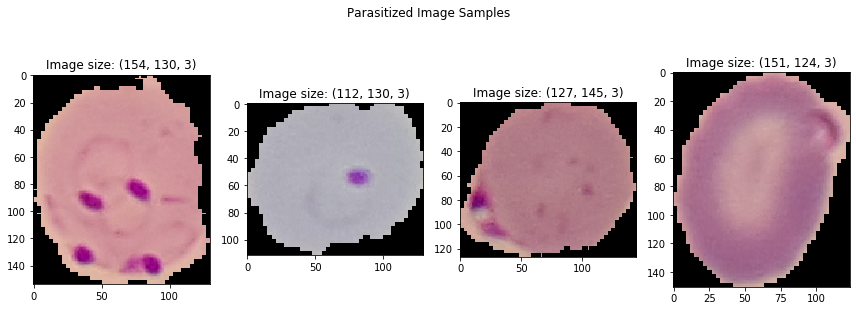

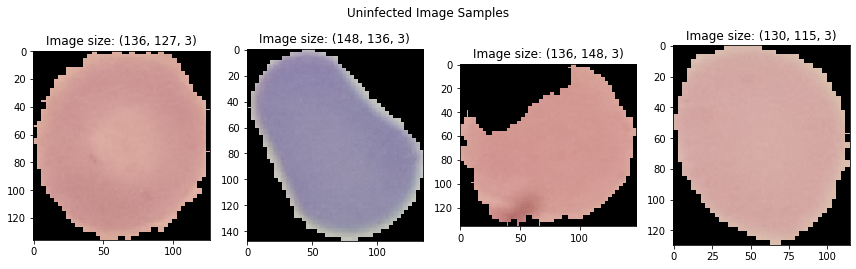

In [26]:
# Look at some sample images
plt.figure(figsize=(12,5))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    img = plt.imread(data_path + '/Parasitized/' + parasitized_data[i])
    plt.imshow(img)
    plt.title('Image size: ' + str(np.shape(img)))
    plt.tight_layout()

plt.suptitle('Parasitized Image Samples')
plt.show()

plt.figure(figsize=(12,4))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    img = plt.imread(data_path + '/Uninfected/' + uninfected_data[i + 1])
    plt.imshow(img)
    plt.title('Image size: ' + str(np.shape(img)))
    plt.tight_layout()

plt.suptitle('Uninfected Image Samples')
plt.show()

# NOTE: The images are of different size. Also they are RGB images.

### The dataset preprocessing so far has been to help you, you should not change anything. However, from now on, take nothing for granted.

In [27]:
# Create dataset for machine learning purposes.

print("Loading data, this may take a while ...")

height = 20
width = 20
# NOTE: The size of the new images is very important.

data = []
labels = []
for img in parasitized_data:
    try:
        img_read = plt.imread(data_path + '/Parasitized/' + "/" + img)
        img_resize = cv2.resize(img_read, (height, width))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(1)
    except:
        None

for img in uninfected_data:
    try:
        img_read = plt.imread(data_path + '/Uninfected' + "/" + img)
        img_resize = cv2.resize(img_read, (height, width))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(0)
    except:
        None

print("Done!")

# NOTE: The labels are 1 if the corresponding image is paratisized, 0 if not.

Loading data, this may take a while ...
Done!


In [28]:
image_data = np.array(data)
labels = np.array(labels)

# Shuffle data
idx = np.arange(image_data.shape[0])
np.random.shuffle(idx)
image_data = image_data[idx]
labels = labels[idx]

# Sizes of datasets
print(f"Input data shape : {np.shape(image_data)}")
print(f"Output data shape: {np.shape(labels)}")

Input data shape : (27558, 20, 20, 3)
Output data shape: (27558,)


In [0]:
# Split dataset into training and testing dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=101)
# NOTE: Keep the ratio of the split as it is. It will make evaluation easier for us. 
# NOTE: The split should be reproducible, hence the random state.

# Split testing dataset into testing and validation
x_test, x_val = x_test[0:int(len(x_test) / 2), :], x_test[int(len(x_test) / 2):, :]
y_test, y_val = y_test[0:int(len(y_test) / 2)], y_test[int(len(y_test) / 2):]

# Two samples from the testing set for heatmapping
x_call, y_call = x_test[[np.argmin(y_test), np.argmax(y_test)]], y_test[[np.argmin(y_test), np.argmax(y_test)]]

# NOTE: Pick one parasitized and one uninfected too.

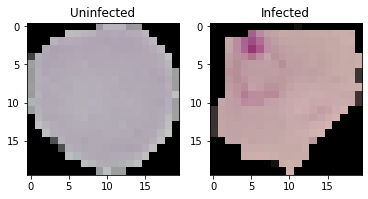

In [30]:
plt.subplot(121)
plt.imshow(x_call[0, :, :, :])
plt.title("Uninfected")
plt.subplot(122)
plt.imshow(x_call[1, :, :, :])
plt.title("Infected")
plt.show()

In [0]:
# Make the labels keras-friendly
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [32]:
# A quick summary of the data:
print(f"Training image size  : {str(x_train.shape)}")
print(f"Validation image size: {str(x_val.shape)}")
print(f"Testing image size   : {str(x_test.shape)}")
print("")
print(f"Training label size  : {str(y_train.shape)}")
print(f"Validating label size: {str(y_val.shape)}")
print(f"Testing label size   : {str(y_test.shape)}")

Training image size  : (22046, 20, 20, 3)
Validation image size: (2756, 20, 20, 3)
Testing image size   : (2756, 20, 20, 3)

Training label size  : (22046, 2)
Validating label size: (2756, 2)
Testing label size   : (2756, 2)


In [0]:
# Import packages important for building and training your model.

import tensorflow.keras

from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

from keras.preprocessing.image import ImageDataGenerator

In [131]:
## Data augmentation

x_train_dataaug = x_train.copy()
y_train_dataaug = y_train.copy()

for img in range(0,22046-1):

  x_rotatedImage = np.rot90(x_train[img], axes=(0,1))
  y_rotatedImage = y_train[img]

  x_rotatedImage = np.expand_dims(x_rotatedImage, axis=0)

  x_train_dataaug = np.vstack((x_train_dataaug, x_rotatedImage))
  y_train_dataaug = np.vstack((y_train_dataaug, y_rotatedImage))


(22046, 20, 20, 3)
(22046, 2)
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.840902   0.5996667  0.56668633]
 [0.8415098  0.5692157  0.5665687 ]
 [0.84313726 0.56078434 0.5647059 ]
 [0.83137256 0.54901963 0.5529412 ]
 [0.828902   0.5465491  0.5504706 ]
 [0.833549   0.5511961  0.55511767]
 [0.8290588  0.54670596 0.55062747]
 [0.8392157  0.5496079  0.55352944]
 [0.845255   0.56494117 0.5678432 ]
 [0.8494117  0.5787451  0.57339215]
 [0.85484314 0.6253726  0.58605886]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[0. 1.]
(22046, 20, 20, 3)
(22046, 2)
(44091, 20, 20, 3)
(44091, 2)


In [0]:
def build_model(height, width, classes, channels):
    model = Sequential()
    inputShape = (height, width, channels)
    chanDim = -1

    if K.image_data_format() == 'channels_first':
        inputShape = (channels, height, width)
  
    model.add(Conv2D(8, (3, 3), strides=(1, 1), input_shape=inputShape, name='hotmap', padding='same'))
    model.add(Conv2D(6, (3, 3), strides=(1, 1), padding='same'))
    model.add(Conv2D(4, (3, 3), strides=(1, 1), use_bias=True, padding='same'))
    model.add(Conv2D(1, (3, 3), strides=(1, 1), use_bias=True, padding='same'))

    model.add(Flatten())

    model.add(Dense(128, activation='relu')) #512
    model.add(Dense(128, activation='relu')) # 128
    model.add(Dense(classes, activation='relu'))

    return model

# NOTE: Look at the imported layers in the previous cell. Feel free to use all of them.
# NOTE: Are you satisfied with the model being sequential? Feel free to experiment.
# NOTE: The first activation layer is named 'hotmap' for further use for heatmapping.
# NOTE: What activation are you using on the output layer? What range will your output have?

In [134]:
# Build your model.

classes = 2
channels = 3
model = build_model(height=height, width=width, classes=classes, channels=channels)
print(f'Size of the model input: {str(model.input.shape)}')
model.summary()

# NOTE: Are the input sizes correct?
# NOTE: Are the output sizes correct?
# NOTE: Is the 'hotmap' activation layer in the model?
# NOTE: Try to imagine the model layer-by-layer and think it through. Is it doing something reasonable?
# NOTE: Are the model parameters split "evenly" between the layers? Or is there one huge layer?
# NOTE: Will the model fit into memory? Is the model too small? Is the model too large?

Size of the model input: (?, 20, 20, 3)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hotmap (Conv2D)              (None, 20, 20, 8)         224       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 20, 20, 6)         438       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 20, 20, 4)         220       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 20, 1)         37        
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               51328     
_________________________________________________________________
dense_10 (Dens

In [0]:
# Compile the model, try out different optimizers
learning_rate = 0.01 # 0.01
optim = optimizers.SGD(lr=learning_rate)
model.compile(loss='mean_squared_error', # mean_squared_error
              optimizer=optim,
              metrics=['accuracy'])

#model.compile(loss='binary_crossentropy',
#              optimizer='rmsprop',
#              metrics=['accuracy'])

# NOTE: Are you satisfied with the loss function?
# NOTE: Are you satisfied with the metric?
# NOTE: Are you satisfied with the optimizer and its parameters?

In [137]:
#fit the model onto the dataset
batch_size = 16 # 16
n_epochs = 35 # 60

h = model.fit(x_train_dataaug, y_train_dataaug, epochs=n_epochs, batch_size=batch_size)


#NOTE: Plotting the accuracies and losses helps a lot.
# NOTE: What does plotting the training data tell you? Should you plot something else?
# NOTE: What should one do with the validation data?
# NOTE: When should one stop? Did you overtrain? Did you train for long enough?
# NOTE: Think about implementing Early Stopping?

Train on 44091 samples
Epoch 1/35
44091/44091 [==============================] - 11s 259us/sample - loss: 0.1277 - acc: 0.8411
Epoch 2/35
44091/44091 [==============================] - 11s 254us/sample - loss: 0.0740 - acc: 0.9181
Epoch 3/35
44091/44091 [==============================] - 11s 249us/sample - loss: 0.0619 - acc: 0.9294
Epoch 4/35
44091/44091 [==============================] - 11s 253us/sample - loss: 0.0559 - acc: 0.9354
Epoch 5/35
44091/44091 [==============================] - 11s 261us/sample - loss: 0.0521 - acc: 0.9393
Epoch 6/35
44091/44091 [==============================] - 11s 251us/sample - loss: 0.0496 - acc: 0.9419
Epoch 7/35
44091/44091 [==============================] - 11s 256us/sample - loss: 0.0475 - acc: 0.9445
Epoch 8/35
44091/44091 [==============================] - 11s 253us/sample - loss: 0.0460 - acc: 0.9449
Epoch 9/35
44091/44091 [==============================] - 11s 252us/sample - loss: 0.0448 - acc: 0.9465
Epoch 10/35
44091/44091 [================

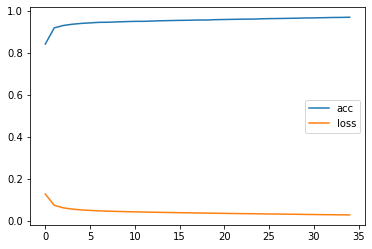

In [138]:
# Plotting loss + validation 
plt.figure()
plt.plot(h.history['acc'])
plt.plot(h.history['loss'])
plt.legend(['acc', 'loss'])
plt.show()

In [0]:
# Grad-GAM heatmaps
# Note: You need to install tf-explain for this to work
try:
    from tf_explain.core.grad_cam import GradCAM

    class_index = 1
    explainer = GradCAM()
    # Compute GradCAM
    grid = explainer.explain((x_call, y_call), model, class_index=class_index, layer_name="hotmap")
    plt.imshow(np.sum(grid, axis=2), cmap='bwr')
    plt.colorbar()
    plt.show()

    # NOTE: We look at the activation function of the layer called 'hotmap' from the model.
    # NOTE: What does this image mean?
except:
    pass

In [140]:
# Evaluate the model on the validation data. Its this value that should exceed 0.96 (i.e., 95 %).
predictions = model.evaluate(x_val, y_val, verbose=0)
print(f"Validation loss    : {predictions[0]:.3f}")
print(f"Validation accuracy: {predictions[1]:.3f}")

# NOTE: Is this high enough? How about varying model hyper-parameters? Perhaps implement data augmentation?

Validation loss    : 0.043
Validation accuracy: 0.949


In [141]:
# Final model's test error. Note that you should _NOT_ look at this value until you are
# completely happy with your model. Report this value in the report.
if True:
    predictions = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test loss    : {predictions[0]:.3f}")
    print(f"Test accuracy: {predictions[1]:.3f}")

Test loss    : 0.043
Test accuracy: 0.951
